In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The dataset "Sentiment 140" consists of 1.6 million tweets extracted using the Twitter API. The tweets are labeled as follows:

* 0 for negative sentiment
* 4 for positive sentiment

1. Importing the libraries

In [1]:
# importing some required libraries
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 
nltk.download('stopwords') 



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

2. Importing Dataset

Instead of using 'target' as given in the Kaggle repository, we will use 'sentiment'.


In [2]:
DATASET_ENCODING = "ISO-8859-1"
DATASET_COLUMNS = ["sentiment", "id", "date", "query", "user_id", "text"]
df= pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
# Getting Null Values Count

np.sum(df.isnull().any(axis=1))

0

In [4]:
# Getting Dataset info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   query      1600000 non-null  object
 4   user_id    1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
# Removing the unnecessary columns.
df = df.drop(["id", "date", "query", "user_id"], axis=1)


In [6]:
# Postive review is marked as 4, changing it to 1 and Negative review is 0.

df['sentiment'] = df['sentiment'].replace(4,1)

In [7]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


3. Data Visualization

sentiment
negative    800000
positive    800000
Name: count, dtype: int64


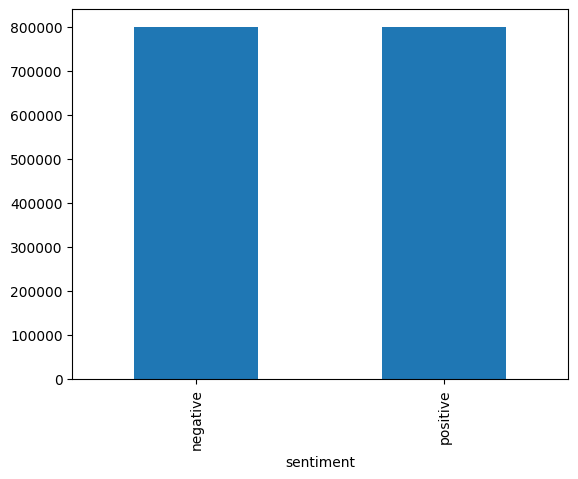

In [8]:
# Visualising the distribution of the sentiment variable.

sentiment = {0:"negative", 1:"positive"}
print(df.sentiment.apply(lambda x: sentiment[x]).value_counts())
df.sentiment.apply(lambda x: sentiment[x]).value_counts().plot(kind = 'bar')
plt.show()

With 800000 positive sentiment tweets and 800000 negative sentiment tweets, the dataset is balanced in terms of sentiment labels. This balance suggests that there are an equal number of positive and negative sentiment tweets, which can be advantageous for training machine learning models

4. Data Preprocessing

In [9]:
stopWords = stopwords.words('english') 
stemmer = SnowballStemmer('english') 

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"  






In [10]:
def preprocess(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stopWords:
            tokens.append(token)
    return " ".join(tokens)  







#Joins the filtered tokens back together using " "

In [11]:
df['text'] = df['text'].map(preprocess)

print(f'Text Preprocessing complete.')

Text Preprocessing complete.


5. Splitting the Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'],
                                                    test_size = 0.2, random_state = 0)

In [14]:
# Printing the shape of training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (1280000,) (1280000,)
Testing set shape: (320000,) (320000,)


6. TF-IDF Vectoriser

TF-IDF:is a statistical measure that evaluates the importance of a word in a document relative to a collection of documents

In [15]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [16]:
#transforming the dataset into matrix of TF-IDF Features by using the TF-IDF Vectoriser
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)


7. Model Building

Accuracy: 0.7783625
F1 Score: 0.7780489942043135


Text(0.5, 1.0, 'Confusion Matrix')

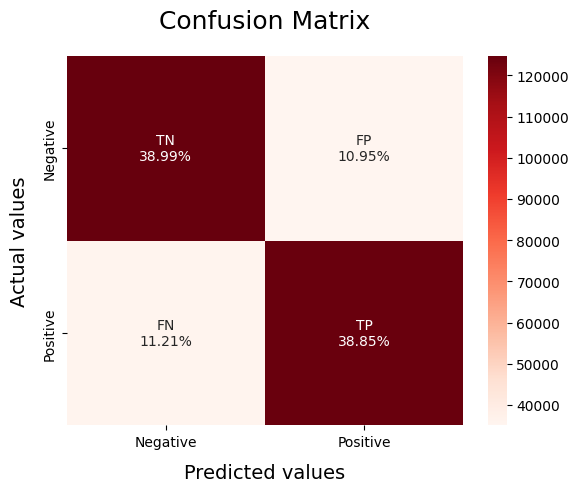

In [21]:
# Train the Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)
# Predict with the Naive Bayes classifier on the test set
naive_bayes_predictions = naive_bayes_classifier.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, naive_bayes_predictions)
print("Accuracy:", accuracy)

# Calculate the F1 score
f1 = f1_score(y_test, naive_bayes_predictions)
print("F1 Score:", f1)

# Compute and plot the Confusion matrix
conf_matrix = confusion_matrix(y_test, naive_bayes_predictions)
categories  = ['Negative','Positive']
group_names = ['TN','FP', 'FN','TP']
group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(conf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [22]:
from sklearn.model_selection import GridSearchCV

# Définir les paramètres à tester
parameters = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}

# Initialiser le classificateur Naive Bayes
naive_bayes_classifier = MultinomialNB()

# Créer un objet GridSearchCV
grid_search = GridSearchCV(naive_bayes_classifier, parameters, cv=5, scoring='accuracy')

# Exécuter la recherche sur la grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Best Parameters:", grid_search.best_params_)

# Utiliser le modèle avec les meilleurs paramètres pour prédire sur le jeu de test
best_naive_bayes = grid_search.best_estimator_
best_naive_bayes_predictions = best_naive_bayes.predict(X_test)

# Calculer l'accuracy et le F1 score avec les meilleurs paramètres
accuracy_best = accuracy_score(y_test, best_naive_bayes_predictions)
print("Accuracy with Best Parameters:", accuracy_best)

f1_best = f1_score(y_test, best_naive_bayes_predictions)
print("F1 Score with Best Parameters:", f1_best)


Best Parameters: {'alpha': 2.0}
Accuracy with Best Parameters: 0.779834375
F1 Score with Best Parameters: 0.7790881070114983


In [17]:
from sklearn.linear_model import LogisticRegression

# Initialisation du modèle
logistic_regression_model = LogisticRegression()

In [18]:
logistic_regression_model.fit(X_train, y_train)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [19]:
# Predict with the Naive Bayes classifier on the test set
logistic_regression_prediction = logistic_regression_model.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, logistic_regression_prediction)
print("Accuracy:", accuracy)

# Calculate the F1 score
f1 = f1_score(y_test, logistic_regression_prediction)
print("F1 Score:", f1)

Accuracy: 0.794409375
F1 Score: 0.7981455742614053


Text(0.5, 1.0, 'Confusion Matrix')

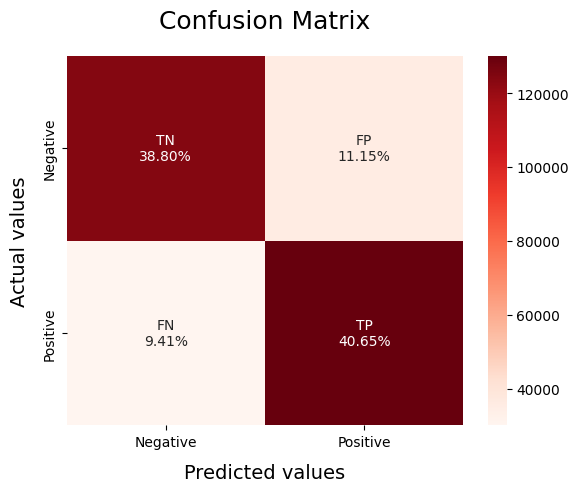

In [20]:
# Compute and plot the Confusion matrix
conf_matrix = confusion_matrix(y_test, logistic_regression_prediction)
categories  = ['Negative','Positive']
group_names = ['TN','FP', 'FN','TP']
group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(conf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)


plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


In [22]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'solver': ['liblinear']  # Algorithm to use in the optimization problem
}
# Instantiate the GridSearchCV object
grid_search = GridSearchCV(logistic_regression_model, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best estimator
best_estimator = grid_search.best_estimator_

# Evaluate the best estimator on the test set
accuracy = best_estimator.score(X_test, y_test)
print("Accuracy on Test Set:", accuracy)

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy on Test Set: 0.794428125


In [ ]:
# Train the Naive Bayes classifier
#svm_classifier = SVC() 
#svm_classifier.fit(X_train, y_train)



In [ ]:
# Predict with the Naive Bayes classifier on the test set
#svm_predictions = svm_classifier.predict(X_test)
# Calculate accuracy
#accuracy = accuracy_score(y_test, svm_predictions)
#print("Accuracy:", accuracy)

# Calculate the F1 score
#f1 = f1_score(y_test, svm_predictions)
#print("F1 Score:", f1)

In [ ]:

# Calculate the confusion matrix
# Compute and plot the Confusion matrix
#conf_matrix = confusion_matrix(y_test, svm_predictions)
#categories  = ['Negative','Positive']
#group_names = ['TN','FP', 'FN','TP']
#group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]

#labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
#labels = np.asarray(labels).reshape(2,2)

#sns.heatmap(conf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                #xticklabels = categories, yticklabels = categories)


#plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
#plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
#plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
# Calculate the confusion matrix
# Compute and plot the Confusion matrix
#conf_matrix = confusion_matrix(y_test, svm_predictions)
#categories  = ['Negative','Positive']
#group_names = ['TN','FP', 'FN','TP']
#group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]

#labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
#labels = np.asarray(labels).reshape(2,2)

#sns.heatmap(conf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                #xticklabels = categories, yticklabels = categories)


#plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
#plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
#plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
#random_forest_classifier = RandomForestClassifier()

#random_forest_classifier.fit(X_train, y_train)
# Predict with the Naive Bayes classifier on the test set
#random_forest_predictions = random_forest_classifier.predict(X_test)
# Calculate accuracy
#accuracy = accuracy_score(y_test, random_forest_predictions)
#print("Accuracy:", accuracy)

# Calculate the F1 score
#f1 = f1_score(y_test, random_forest_predictions)
#print("F1 Score:", f1)

# Calculate the confusion matrix

# Compute and plot the Confusion matrix
#conf_matrix = confusion_matrix(y_test, random_forest_predictions)
#categories  = ['Negative','Positive']
#group_names = ['TN','FP', 'FN','TP']
#group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]

#labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
#labels = np.asarray(labels).reshape(2,2)

#sns.heatmap(conf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                #xticklabels = categories, yticklabels = categories)

#plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
#plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
#plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
